In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

np.random.seed(123)
tf.random.set_seed(123)

In [2]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [3]:
df0 = pd.read_csv('Datasets/sp500sub.csv', index_col='Date', parse_dates=True)

In [4]:
df = df0[df0['Name'] == 'SBUX'][['Close']].copy()

In [5]:
df['LogClose'] = np.log(df['Close'])

In [6]:
df['DiffLogClose'] = df['LogClose'].diff()

In [7]:
Ntest = 21
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [8]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['DiffLogClose']])
test_scaled = scaler.transform(test[['DiffLogClose']])

In [9]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [10]:
df.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
df.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()

In [11]:
# Make supervised dataset
series = df['ScaledLogReturn'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2252, 10) Y.shape (2252,)


In [12]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [13]:
# Basic ANN
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(1)(x)
model = Model(i, x)

In [14]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [15]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=200,
  validation_data=(Xtest, Ytest)
)

Epoch 1/200
70/70 [==============================] - 2s 5ms/step - loss: 1.2624 - val_loss: 1.2555
Epoch 2/200
70/70 [==============================] - 0s 3ms/step - loss: 1.0862 - val_loss: 1.1691
Epoch 3/200
70/70 [==============================] - 0s 3ms/step - loss: 1.0438 - val_loss: 1.1290
Epoch 4/200
70/70 [==============================] - 0s 3ms/step - loss: 1.0239 - val_loss: 1.1203
Epoch 5/200
70/70 [==============================] - 0s 3ms/step - loss: 1.0134 - val_loss: 1.0896
Epoch 6/200
70/70 [==============================] - 0s 3ms/step - loss: 1.0012 - val_loss: 1.0793
Epoch 7/200
70/70 [==============================] - 0s 3ms/step - loss: 0.9914 - val_loss: 1.0759
Epoch 8/200
70/70 [==============================] - 0s 4ms/step - loss: 0.9828 - val_loss: 1.0584
Epoch 9/200
70/70 [==============================] - 0s 3ms/step - loss: 0.9775 - val_loss: 1.0768
Epoch 10/200
70/70 [==============================] - 0s 3ms/step - loss: 0.9733 - val_loss: 1.0628
Epoch 11/

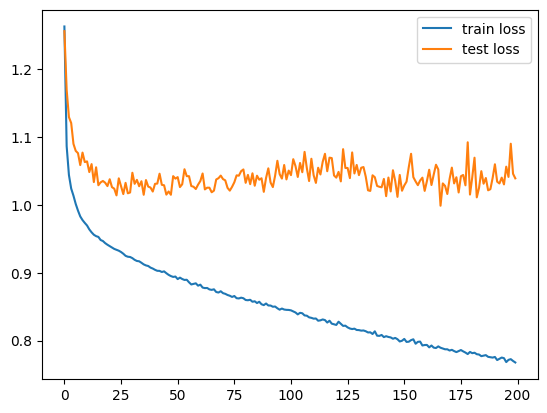

In [16]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [17]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [18]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

Ptrain = scaler.inverse_transform(Ptrain).flatten()
Ptest = scaler.inverse_transform(Ptest).flatten()

1/1 [==============================] - 0s 17ms/step


In [19]:
# Store diff predictions
df.loc[train_idx, 'Diff ANN Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff ANN Test Prediction'] = Ptest

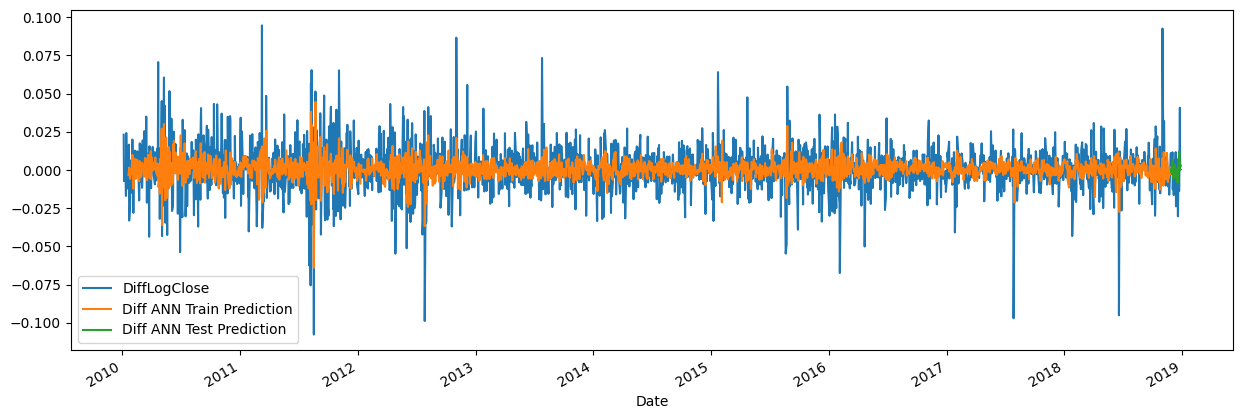

In [20]:
cols = ['DiffLogClose',
        'Diff ANN Train Prediction',
        'Diff ANN Test Prediction']
df[cols].plot(figsize=(15, 5));

In [21]:
# Needed to compute un-differenced predictions
df['ShiftLogClose'] = df['LogClose'].shift(1)
prev = df['ShiftLogClose']

In [22]:
# Last-known train value
last_train = train.iloc[-1]['LogClose']

In [23]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

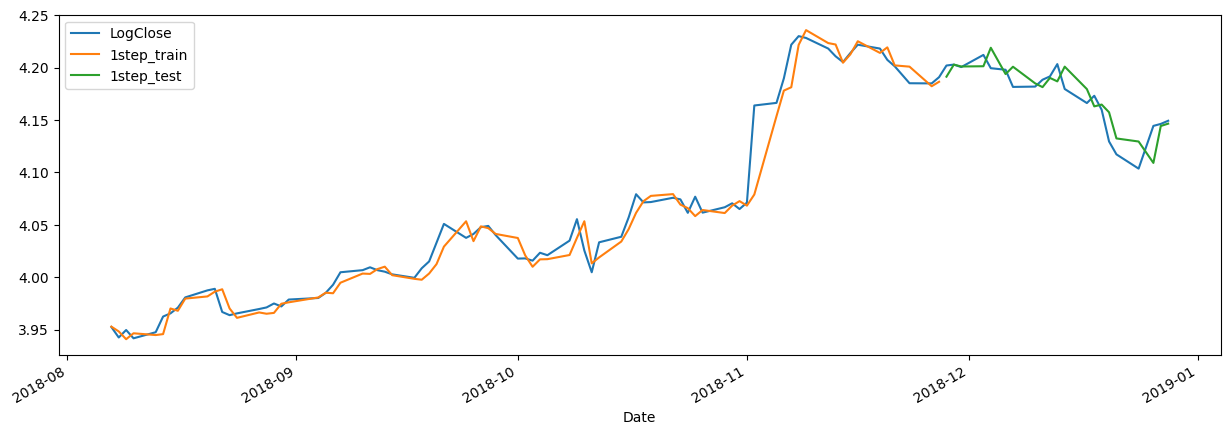

In [24]:
# plot 1-step forecast
df.iloc[-100:][['LogClose', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [25]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1))[0]
  
  # update the predictions list
  multistep_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 [==============================] - 0s 19ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15912\692323302.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_x[-1] = p


1/1 [==============================] - 0s 32ms/step


In [26]:
# unscale
multistep_predictions = np.array(multistep_predictions)
multistep_predictions = scaler.inverse_transform(
    multistep_predictions.reshape(-1, 1)).flatten()

In [27]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

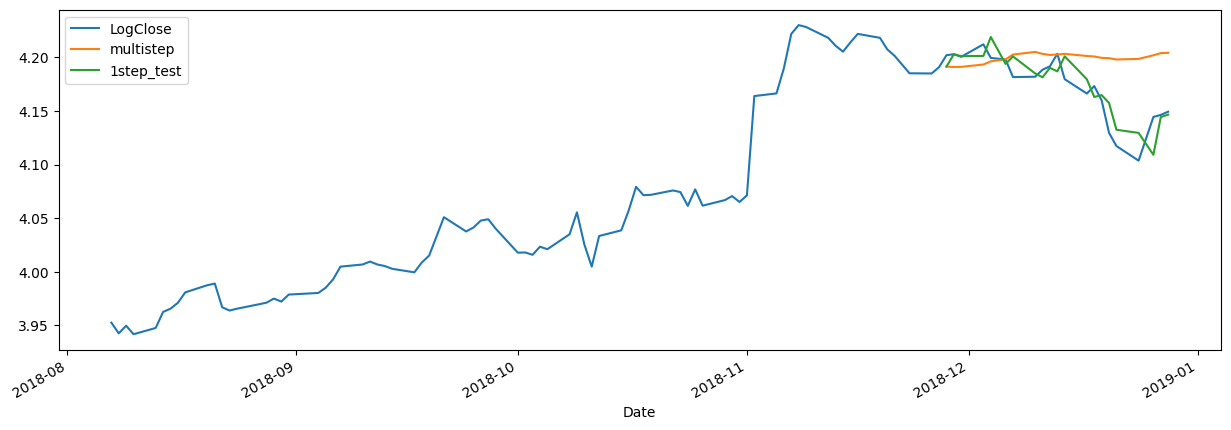

In [28]:
# plot 1-step and multi-step forecast
df.iloc[-100:][['LogClose', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [29]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2232, 10) Y.shape (2232, 21)


In [30]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [31]:
# Basic ANN
i = Input(shape=(Tx,))
x = Dense(32, activation='relu')(i)
x = Dense(Ty)(x)
model = Model(i, x)

In [32]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [33]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=100,
  validation_data=(Xtest_m, Ytest_m)
)

Epoch 1/100
70/70 [==============================] - 1s 4ms/step - loss: 1.1543 - val_loss: 1.1385
Epoch 2/100
70/70 [==============================] - 0s 4ms/step - loss: 1.0630 - val_loss: 1.0664
Epoch 3/100
70/70 [==============================] - 0s 3ms/step - loss: 1.0347 - val_loss: 1.0274
Epoch 4/100
70/70 [==============================] - 0s 3ms/step - loss: 1.0203 - val_loss: 1.0123
Epoch 5/100
70/70 [==============================] - 0s 3ms/step - loss: 1.0121 - val_loss: 0.9971
Epoch 6/100
70/70 [==============================] - 0s 3ms/step - loss: 1.0065 - val_loss: 0.9855
Epoch 7/100
70/70 [==============================] - 0s 3ms/step - loss: 1.0027 - val_loss: 0.9874
Epoch 8/100
70/70 [==============================] - 0s 3ms/step - loss: 0.9997 - val_loss: 0.9779
Epoch 9/100
70/70 [==============================] - 0s 3ms/step - loss: 0.9975 - val_loss: 0.9779
Epoch 10/100
70/70 [==============================] - 0s 3ms/step - loss: 0.9957 - val_loss: 0.9713
Epoch 11/

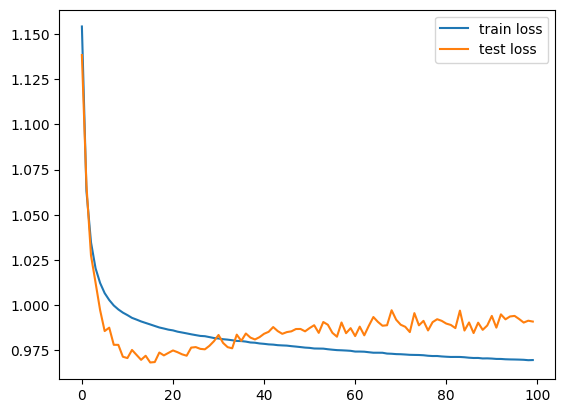

In [34]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [35]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

1/1 [==============================] - 0s 23ms/step


In [36]:
Ptrain.shape, Ptest.shape

((2231, 21), (21, 21))

In [37]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [38]:
# unscale
Ptest = scaler.inverse_transform(Ptest.reshape(-1, 1)).flatten()

In [39]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
  np.cumsum(Ptest)

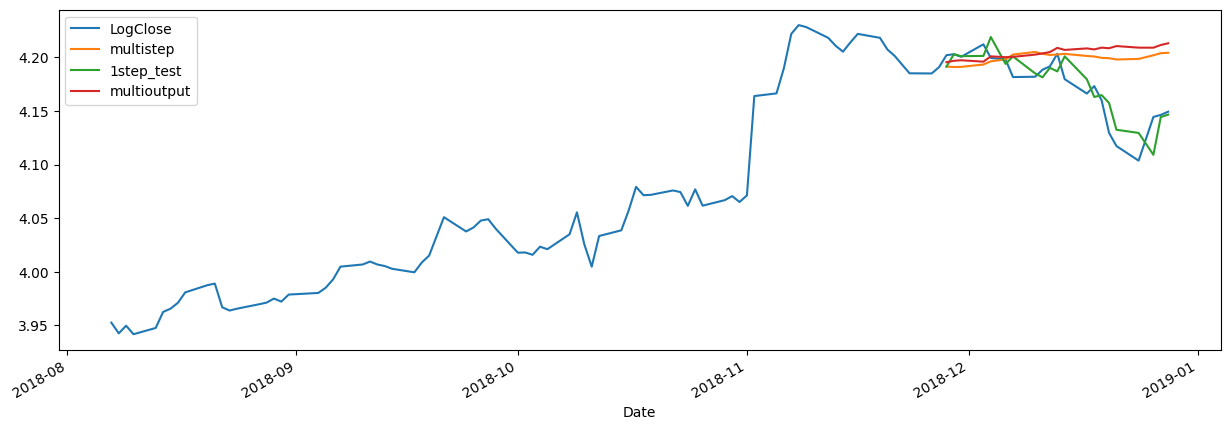

In [40]:
# plot all forecasts
cols = ['LogClose', 'multistep', '1step_test', 'multioutput']
df.iloc[-100:][cols].plot(figsize=(15, 5));

In [41]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogClose']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.007640911092216711
multi-output MAPE: 0.008421328587945028


## 1-Step Binary Classification

In [42]:
Ytrain_b = (Ytrain > 0) * 1
Ytest_b = (Ytest > 0) * 1

In [43]:
# Basic ANN
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(1)(x)
model = Model(i, x)

In [44]:
model.compile(
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy'],
)

In [45]:
r = model.fit(
  Xtrain,
  Ytrain_b,
  epochs=100,
  validation_data=(Xtest, Ytest_b)
)

Epoch 1/100
70/70 [==============================] - 1s 5ms/step - loss: 0.7045 - accuracy: 0.5043 - val_loss: 0.6730 - val_accuracy: 0.5238
Epoch 2/100
70/70 [==============================] - 0s 5ms/step - loss: 0.6957 - accuracy: 0.5096 - val_loss: 0.6772 - val_accuracy: 0.5238
Epoch 3/100
70/70 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5119 - val_loss: 0.6741 - val_accuracy: 0.5238
Epoch 4/100
70/70 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.5074 - val_loss: 0.6818 - val_accuracy: 0.5238
Epoch 5/100
70/70 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5083 - val_loss: 0.6765 - val_accuracy: 0.5238
Epoch 6/100
70/70 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.5078 - val_loss: 0.6773 - val_accuracy: 0.5238
Epoch 7/100
70/70 [==============================] - 0s 3ms/step - loss: 0.6848 - accuracy: 0.5096 - val_loss: 0.6741 - val_accuracy: 0.5238
Epoch 8/100
7

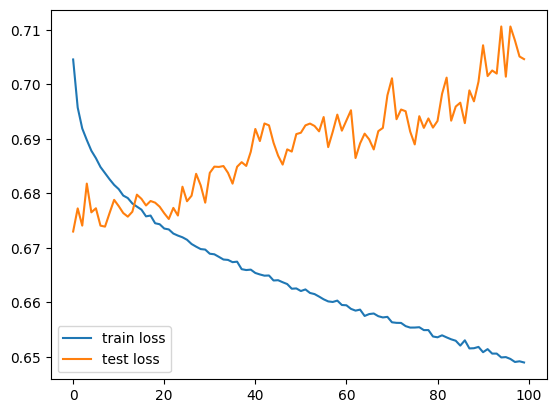

In [46]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

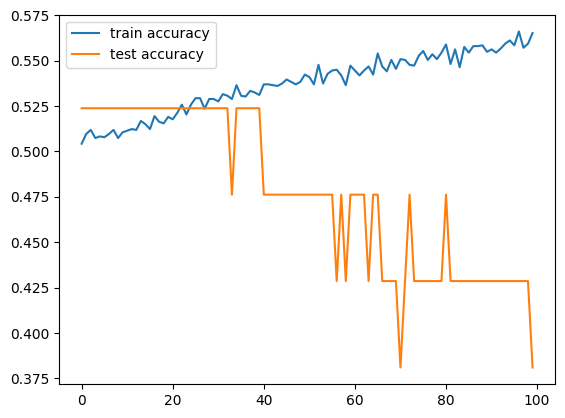

In [47]:
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='test accuracy')
plt.legend();

In [ ]:
# Exercise:
# Do you think differencing is unnecessary? Try it!
# Do you think logging is unnecessary? Try it!
# Do you think including more past lags would be useful?
# Have you considered walk-forward validation to optimize hyperparameters?
# What is a better metric?